In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Import scikit-learn tools for preprocessing and models
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
)
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR

# Import NLTK tools for sentiment analysis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("all")

import warnings

warnings.filterwarnings("ignore")

In [52]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

# Import Data

In [53]:
# reviews_df = pd.read_csv('data/steam_review_data1.csv.gz', compression='gzip')

In [54]:
sent_df = pd.read_csv("data/steam_review_sentiment.csv.gz", compression="gzip")

In [55]:
games_df = pd.read_csv("data/steamspy_data.csv")

In [56]:
games_df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags
0,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,178,196,128,999.0,999.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,16360,"{'Action': 5379, 'FPS': 4801, 'Multiplayer': 3..."
1,20,Team Fortress Classic,Valve,Valve,NaN,5412,895,0,"5,000,000 .. 10,000,000",551,58,14,58,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,87,"{'Action': 745, 'FPS': 306, 'Multiplayer': 257..."
2,30,Day of Defeat,Valve,Valve,NaN,5003,556,0,"5,000,000 .. 10,000,000",421,73,23,73,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 787, 'World War II': 248, 'Multiplayer..."
3,40,Deathmatch Classic,Valve,Valve,NaN,1852,412,0,"5,000,000 .. 10,000,000",318,0,7,0,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,7,"{'Action': 629, 'FPS': 139, 'Classic': 107, 'M..."
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,13262,662,0,"5,000,000 .. 10,000,000",676,0,150,0,499.0,499.0,0.0,"English, French, German, Korean",Action,122,"{'FPS': 881, 'Action': 322, 'Classic': 251, 'S..."


# Sentiment analysis

We will run sentiment analysis to access sentiment components for each review. Due to the size of our reviews dataset the sentiment analysis writes to a .csv file. This file will be used for further analysis and the code below has been commented out.

In [ ]:
# def preprocess_text(text):
#     # Tokenize the text
#     tokens = word_tokenize(text.lower())

#     # Remove stop words
#     filtered_tokens = [
#         token for token in tokens if token not in stopwords.words("english")
#     ]

#     # Lemmatize the tokens
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [
#         lemmatizer.lemmatize(token) for token in filtered_tokens
#     ]

#     # Join the tokens back into a string
#     processed_text = " ".join(lemmatized_tokens)
#     return processed_text

In [ ]:
# # initialize NLTK sentiment analyzer
# analyzer = SentimentIntensityAnalyzer()


# # create get_sentiment function
# def get_sentiment(text):
#     scores = analyzer.polarity_scores(text)

#     return scores

In [ ]:
# review_df = review_df.dropna()

In [ ]:
# review_df["review_processed"] = review_df["review"].apply(preprocess_text)
# review_df["sentiment"] = review_df["review_processed"].apply(get_sentiment)

In [ ]:
# reduced_df = review_df[["appid", "sentiment"]]
# reduced_df.to_csv(
#     "data/steam_review_sentiment.csv.gz", index=False, compression="gzip"
# )

## Reformatting
Our sentiment dataframe has a dictionary of sentiment scores for each review. The issue is that it is imported as a string, so we need to convert it to a dictionary.

In [57]:
sent_df["sentiment"]

0          {'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'comp...
1          {'neg': 0.051, 'neu': 0.718, 'pos': 0.231, 'co...
2          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3          {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...
4          {'neg': 0.015, 'neu': 0.607, 'pos': 0.378, 'co...
                                 ...                        
1336150    {'neg': 0.0, 'neu': 0.268, 'pos': 0.732, 'comp...
1336151    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1336152    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1336153    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1336154    {'neg': 0.119, 'neu': 0.361, 'pos': 0.521, 'co...
Name: sentiment, Length: 1336155, dtype: object

We will run a functions which swaps single quotes for double quotes, and then converts the string to a dictionary using json.loads.

In [60]:
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", '"')
    return json.loads(dict_string)

In [61]:
sent_df["sentiment"] = sent_df["sentiment"].apply(string_to_dict)

In [62]:
# Use json normalize to write the dict to a dataframe
expanded = pd.json_normalize(sent_df["sentiment"])

,neg,neu,pos,compound
0,0.000,0.312,0.688,0.7650
1,0.051,0.718,0.231,0.8519
2,0.000,1.000,0.000,0.0000
3,0.756,0.244,0.000,-0.4767
4,0.015,0.607,0.378,0.9769


In [63]:
# Concat the sentiment back onto the sentiment df with appids
sent_df = pd.concat([sent_df, expanded], axis=1)

In [64]:
# Drop the original sentiment column
sent_df = sent_df.drop(columns=["sentiment"])
sent_df.head()

,appid,neg,neu,pos,compound
0,10,0.000,0.312,0.688,0.7650
1,10,0.051,0.718,0.231,0.8519
2,10,0.000,1.000,0.000,0.0000
3,10,0.756,0.244,0.000,-0.4767
4,10,0.015,0.607,0.378,0.9769


In [66]:
sent_df.groupby("appid").mean()

,neg,neu,pos,compound
appid,,,,
10,0.104010,0.634990,0.261020,0.314473
20,0.086660,0.646980,0.236370,0.194547
30,0.124350,0.593440,0.252200,0.292516
40,0.124160,0.566930,0.288850,0.367227
50,0.077660,0.662680,0.239630,0.377009
...,...,...,...,...
1843760,0.124540,0.640300,0.235110,0.345004
1846330,0.127690,0.605738,0.266595,0.149833
1849310,0.125000,0.708000,0.167000,0.320000


# Addressing Null Values

In [ ]:
games_df[["positive", "negative"]].isna().sum()

positive    0
negative    0
dtype: int64

There are no null values in the positive and negative review counts, so we will create a new variable: `n_reviews` and then reduce our dataset to only those with more than 100 reviews.

Since there is little data for those with less than 100 reviews we will drop those rows in favor of a more robust dataset.

We want to drop the rows at this stage because it will make it easier to fill in the null values.

In [ ]:
# Create a new variable for number of reviews
games_df["n_reviews"] = games_df["positive"] + games_df["negative"]

In [ ]:
# Filter out games with less than 100 reviews
games_df = games_df[games_df["n_reviews"] >= 100]

In [ ]:
games_df.isna().sum()

appid                  0
name                   1
developer             50
publisher             31
score_rank         14723
positive               0
negative               0
userscore              0
owners                 0
average_forever        0
average_2weeks         0
median_forever         0
median_2weeks          0
price                  2
initialprice           1
discount               1
languages              6
genre                 69
ccu                    0
tags                   0
n_reviews              0
dtype: int64

### Price

We will assume that if the price is null, then the game is free. We will fill in the null values with 0.

In [ ]:
# Assume that games with no price are free
games_df[["price", "initialprice"]] = games_df[
    ["price", "initialprice"]
].fillna(0)

### Score_rank, userscore,  and discount

In [ ]:
games_df.score_rank.value_counts()

score_rank
99.0     8
100.0    5
98.0     4
97.0     1
Name: count, dtype: int64

In [ ]:
games_df.userscore.value_counts()

userscore
0     14723
95        3
77        2
62        1
82        1
83        1
81        1
67        1
74        1
97        1
66        1
46        1
98        1
73        1
65        1
84        1
Name: count, dtype: int64

Since score_rank is mostly null values we are going to drop this column from our dataframe. We will also drop the userscore column since it is mostly 0 values, and will use the positive and negative review counts as our measure of popularity.

In [ ]:
games_df = games_df.drop(columns=["score_rank", "userscore", "discount"])
# reviews_df = reviews_df.drop(columns=['Unnamed: 0', 'recommendationid', 'author', 'author_playtime_last_two_weeks', 'author_last_played', 'author_num_reviews', 'votes_funny', 'weighted_vote_score', 'timestamp_updated', 'steam_purchase', 'received_for_free', 'written_during_early_access'])

In [ ]:
games_df.head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,languages,genre,ccu,tags,n_reviews
0,10,Counter-Strike,Valve,Valve,193046,4940,"10,000,000 .. 20,000,000",8486,178,196,128,999.0,999.0,"English, French, German, Italian, Spanish - Sp...",Action,16360,"{'Action': 5379, 'FPS': 4801, 'Multiplayer': 3...",197986
1,20,Team Fortress Classic,Valve,Valve,5412,895,"5,000,000 .. 10,000,000",551,58,14,58,499.0,499.0,"English, French, German, Italian, Spanish - Sp...",Action,87,"{'Action': 745, 'FPS': 306, 'Multiplayer': 257...",6307
2,30,Day of Defeat,Valve,Valve,5003,556,"5,000,000 .. 10,000,000",421,73,23,73,499.0,499.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 787, 'World War II': 248, 'Multiplayer...",5559
3,40,Deathmatch Classic,Valve,Valve,1852,412,"5,000,000 .. 10,000,000",318,0,7,0,499.0,499.0,"English, French, German, Italian, Spanish - Sp...",Action,7,"{'Action': 629, 'FPS': 139, 'Classic': 107, 'M...",2264
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,13262,662,"5,000,000 .. 10,000,000",676,0,150,0,499.0,499.0,"English, French, German, Korean",Action,122,"{'FPS': 881, 'Action': 322, 'Classic': 251, 'S...",13924


### Genre

There are 69 games in our dataset which have null values for the genre. We will fill these rows with a temporary value of 'No Genre' so that we can easily identify them. We will then decide to drop these rows after we have analysed the genre data.

In [ ]:
games_df["genre"] = games_df["genre"].fillna("No Genre")

### Developer and Publisher

Simlar to genre we will fill in the null values with a temporary value of 'Unknown' so that we can easily identify them. We will then decide to drop these rows after we have analysed the developer and publisher data.

In [ ]:
games_df[["developer", "publisher"]] = games_df[
    ["developer", "publisher"]
].fillna("Unknown")

### Languages



In [ ]:
games_df[games_df["languages"].isna()]

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,languages,genre,ccu,tags,n_reviews
1255,106000,The Cursed Crusade,Unknown,Unknown,195,111,"0 .. 20,000",449,0,449,0,0.0,0.0,NaN,No Genre,3,"{'Action': 32, 'Adventure': 32, 'Medieval': 12...",306
1505,211050,Battle vs Chess,Unknown,Unknown,695,281,"0 .. 20,000",334,0,359,0,0.0,0.0,NaN,No Genre,27,"{'Strategy': 400, 'Chess': 56, 'Casual': 46, '...",976
2890,280620,Fiesta Online,Unknown,Unknown,236,189,"0 .. 20,000",19,0,19,0,0.0,0.0,NaN,No Genre,7,"{'Free to Play': 90, 'Anime': 67, 'Massively M...",425
3101,288570,Wolfenstein: The New Order German Edition,Unknown,Unknown,1077,195,"0 .. 20,000",755,0,831,0,0.0,0.0,NaN,No Genre,90,"{'Action': 87, 'Shooter': 40, 'FPS': 27, 'Sing...",1272
5314,354830,Wolfenstein: The Old Blood German Edition,Unknown,Unknown,485,73,"0 .. 20,000",401,0,595,0,0.0,0.0,NaN,No Genre,40,"{'Action': 38, 'Shooter': 21, 'Singleplayer': ...",558
15469,650500,Wolfenstein II: The New Colossus German Edition,Unknown,Unknown,755,336,"0 .. 20,000",880,0,1393,0,0.0,0.0,NaN,No Genre,135,"{'Action': 41, 'Violent': 35, 'Gore': 32, 'Nud...",1091


Since there are only 6 rows which have no language we will drop these rows

In [ ]:
games_df = games_df[games_df["languages"].notna()]

In [ ]:
games_df.isna().sum()

appid              0
name               1
developer          0
publisher          0
positive           0
negative           0
owners             0
average_forever    0
average_2weeks     0
median_forever     0
median_2weeks      0
price              0
initialprice       0
languages          0
genre              0
ccu                0
tags               0
n_reviews          0
dtype: int64

### Name

There is currently one game which has a null value for `name`. We will fill this value based on the `appid` of the game, when searched on the steam store. 

The name variable is also not very useful for our analysis and may be dropped later in favor of appid.

In [ ]:
games_df[games_df["name"].isna()]

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,languages,genre,ccu,tags,n_reviews
13110,576960,NaN,Nuclear Tales,Unknown,110,26,"20,000 .. 50,000",0,0,0,0,299.0,1499.0,"English, Spanish - Spain, French, German","Adventure, Casual, Indie, RPG, Simulation, Str...",1,"{'Adventure': 377, 'Choose Your Own Adventure'...",136


In [ ]:
games_df["name"] = games_df["name"].fillna("🧠 OUT OF THE BO"')

# Feature Engineering

In [ ]:
games_df["percentage_positive"] = games_df["positive"] / games_df["n_reviews"]
games_df["percentage_negative"] = games_df["negative"] / games_df["n_reviews"]
games_df["review_ratio"] = games_df["positive"] / games_df["negative"]

In [ ]:
games_df["percentage_positive"].describe()

count    14735.000000
mean         0.785684
std          0.154940
min          0.076923
25%          0.705505
50%          0.822733
75%          0.904689
max          1.000000
Name: percentage_positive, dtype: float64

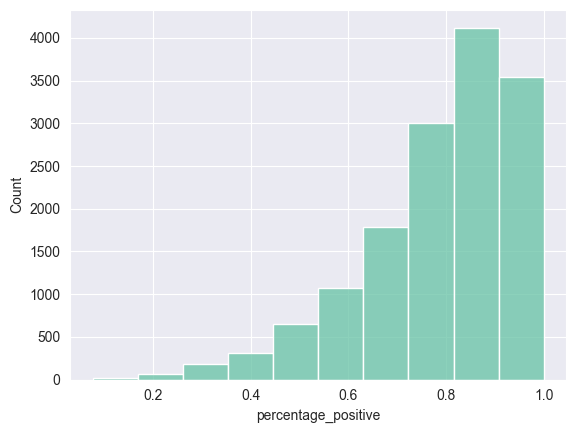

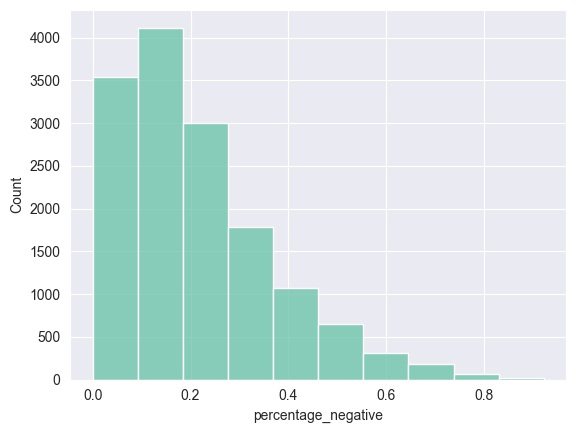

In [ ]:
variables = ["percentage_positive", "percentage_negative"]

for var in variables:
    sns.histplot(games_df[var], bins=10)
    plt.show()

<Axes: xlabel='review_ratio', ylabel='Count'>

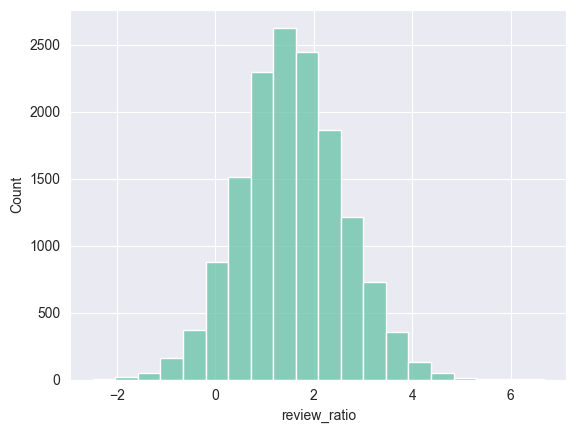

In [ ]:
sns.histplot(np.log(games_df["review_ratio"]), bins=20)

<Axes: xlabel='n_reviews', ylabel='Count'>

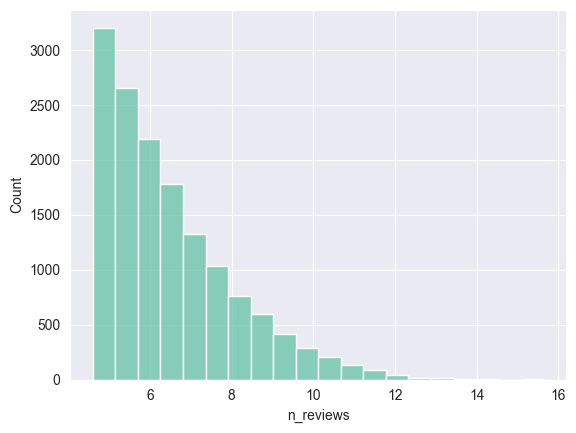

In [ ]:
sns.histplot(np.log(games_df["n_reviews"]), bins=20)

## Genre Encoding

In [ ]:
# Select appid , name, and genre columns
genre_df = games_df[
    [
        "appid",
        "name",
        "genre",
    ]
]
# Encode the genre column with dummies
genres_encoded = genre_df["genre"].str.get_dummies(sep=", ")

# Concatenate the original dataframe and the encoded genres
genres_df = pd.concat([genre_df, genres_encoded], axis=1)
genres_df

,appid,name,genre,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,...,RPG,Racing,Sexual Content,Simulation,Software Training,Sports,Strategy,Utilities,Violent,Web Publishing
0,10,Counter-Strike,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,Action,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62729,1846330,Nope Nope Nurses,Adventure,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62812,1849310,天天地下城,"Action, Adventure, Indie, RPG",1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
62880,1851730,Meow Express,"Adventure, Casual",0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
62905,1852520,元宇宙普信男生存指南,"Adventure, Indie, Simulation",0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Get a count of all the genres
genre_counts = genres_encoded.sum()

# Limit it to genres with more than 10 games
drop_genres = genre_counts[genre_counts < 10].index


# Update the dataframe with only the selected genres
# Also drop original genre column
genres_df.drop(drop_genres, axis=1, inplace=True)
genres_df.drop("genre", axis=1, inplace=True)

In [ ]:
genres_df.head()

,appid,name,Action,Adventure,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,No Genre,RPG,Racing,Simulation,Sports,Strategy
0,10,Counter-Strike,1,0,0,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1,0,0,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,1,0,0,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,1,0,0,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1,0,0,0,0,0,0,0,0,0,0,0,0


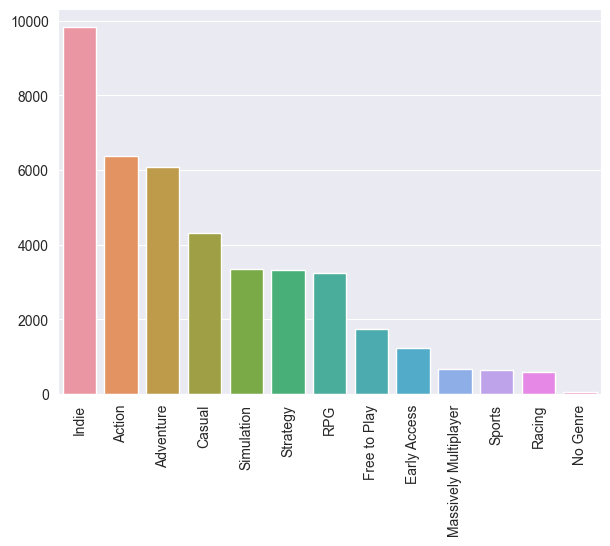

In [ ]:
plt.figure(figsize=(7, 5))
sns.barplot(
    x=genres_df.drop(["appid", "name"], axis=1).columns,
    y=genres_df.drop(["appid", "name"], axis=1).sum(),
    order=genres_df.drop(["appid", "name"], axis=1)
    .sum()
    .sort_values(ascending=False)
    .index,
)
plt.xticks(rotation=90)
plt.show()

Free to play is an interesting column since indicating Free to Play as a genre does not nessecarily indicate that the price of the game is 0. We will remove Free to Play from games which are not free, and add Free to Play to those that are.

In [ ]:
# get a list of all appids that are not free
not_free_games = games_df[games_df["price"] > 0]["appid"].to_list()

# set all free games to 1 and not free games to 0
genres_df[genres_df["appid"].isin(not_free_games)]["Free to Play"] = 0
genres_df[~genres_df["appid"].isin(not_free_games)]["Free to Play"] = 1

## Language Encoding

In [ ]:
games_df["n_languages"] = games_df["languages"].str.split(",").str.len()
games_df.sort_values(by="n_languages", ascending=False).head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,...,initialprice,languages,genre,ccu,tags,n_reviews,percentage_positive,percentage_negative,review_ratio,n_languages
27617,956100,Lovers ' Smiles,S'Games,Lucky Games,732,180,"100,000 .. 200,000",0,0,0,...,99.0,"English, French, Italian, German, Spanish - Sp...","Adventure, Casual, Indie",1,"{'Indie': 158, 'Puzzle': 153, 'Casual': 149, '...",912,0.802632,0.197368,4.066667,29
15658,655100,Oik 3,Crew Lab,Crew Lab,558,77,"50,000 .. 100,000",278,550,395,...,99.0,"English, French, Italian, German, Spanish - Sp...","Casual, Indie",4,"{'Puzzle': 132, 'Minimalist': 126, 'Physics': ...",635,0.878740,0.121260,7.246753,29
24507,873240,Hentai Memory,Pirotexnik,Pirotexnik,948,104,"50,000 .. 100,000",76,0,121,...,99.0,"English, French, Italian, German, Spanish - Sp...","Casual, Indie",5,"{'Nudity': 75, 'Sexual Content': 72, 'Anime': ...",1052,0.901141,0.098859,9.115385,29
38144,1216200,Coloring Game 2,L. Stotch,L. Stotch,2927,87,"200,000 .. 500,000",236,0,322,...,0.0,"English, French, Italian, German, Spanish - Sp...","Casual, Free to Play, Indie",37,"{'Free to Play': 66, 'Casual': 63, 'Indie': 61...",3014,0.971135,0.028865,33.643678,29
33511,1105110,OXXO,Hamster On Coke Games,Hamster On Coke Games,169,7,"0 .. 20,000",45,0,45,...,199.0,"English, French, Italian, German, Spanish - Sp...","Casual, Indie",1,"{'Casual': 22, 'Indie': 21, 'Puzzle': 9}",176,0.960227,0.039773,24.142857,29


<Axes: xlabel='n_languages', ylabel='Count'>

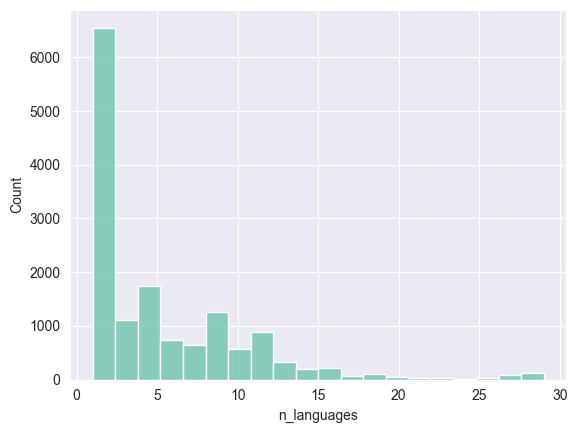

In [ ]:
sns.histplot(games_df["n_languages"], bins=20)

In [ ]:
games_df[games_df["n_languages"] == 1].value_counts("languages")

languages
English                5079
Simplified Chinese       40
Japanese                  5
Russian                   2
Traditional Chinese       2
French                    1
Korean                    1
Thai                      1
Name: count, dtype: int64

# Model  Building

## Feature Selection

In [ ]:
# Select features and target
features = [
    "developer",
    "publisher",
    "genre",
    "price",
    "n_languages",
]  # Add 'categories' if available
X = games_df[features]
y = games_df["percentage_positive"]

We will be creating a regression model to predict the consumer sentiment (represented by percentage of positive reviews) of a a new game entering the marketplace. We will be using the following features:
- developer
- publisher
- genre
- price
- n_languages

These features were chosen as they will be known before the game is released, and are not dependent on the popularity of the game.

## Test and Train Sets

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Model Pipeline

In [ ]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["price", "n_languages"]),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            ["developer", "publisher", "genre"],
        ),
    ]
)


# Model pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_jobs=-1)),
    ]
)

In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Model Selection

We will start with three models

In [ ]:
# Establish our regressors
reg1 = RandomForestRegressor(n_estimators=10, random_state=42)
reg2 = LinearRegression()
reg3 = SVR(kernel="rbf")

### Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning grid
param_grid = {
    "rf": {"n_estimators": [10, 20, 30], "max_depth": [None, 5, 10]},
    "svr": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf", "poly"]},
    "lr": {
        "fit_intercept": [True, False],
    },
}

In [ ]:
models = {"rf": reg1, "lr": reg2, "svr": reg3}

# Use our param grid and GridSearchCV to find the best parameters.
for name, model in models.items():
    grid = GridSearchCV(model, param_grid[name], cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train_prep, y_train)
    print(grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
voting_reg = VotingRegressor(
    [("rf", reg1), ("lr", reg2), ("svr", reg3)], n_jobs=-1
)

In [ ]:
voting_reg.fit(X_train_prep, y_train)

y_pred = gs.predict(X_test_prep)

mean_squared_error(y_test, y_pred)

KeyboardInterrupt: 

## Fit and Predict

In [ ]:
# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 0.026539277479930755


---

In [ ]:
games_df = pd.read_csv("steamspy_data.csv")
reviews_df = pd.read_csv("steam_review_data.csv")

merged_df = pd.merge(games_df, reviews_df, on="appid")

FileNotFoundError: [Errno 2] No such file or directory: 'steamspy_data.csv'

In [ ]:
merged_df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,...,votes_up,votes_funny,weighted_vote_score,comment_count,timestamp_created,timestamp_updated,steam_purchase,received_for_free,written_during_early_access,review
0,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,405,0,0.976047,1,1460808481,1460808481,False,False,False,Best FPS game i ever played
1,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,428,284,0.953599,20,1495993232,1499801573,True,False,False,How to correctly play this game:\n-Noisiest fu...
2,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,248,9,0.950770,220,1480429968,1653066625,True,False,False,[h1]⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀ ♡[/h1]
3,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,2487,4130,0.947676,120,1427890049,1480048737,False,False,False,Ruined my life.
4,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,195,0,0.938016,9,1357415282,1547414438,False,False,False,Actually the best game in this world. It still...


In [ ]:
merged_df["sentiment_ratio"] = merged_df.apply(
    lambda row: row["positive"] / row["negative"]
    if row["negative"] != 0
    else float("inf"),
    axis=1,
)

In [ ]:
average_sentiment = merged_df.groupby("appid")["sentiment_ratio"].mean()

In [ ]:
merged_df[merged_df["appid"] == 10]

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,...,votes_funny,weighted_vote_score,comment_count,timestamp_created,timestamp_updated,steam_purchase,received_for_free,written_during_early_access,review,sentiment_ratio
0,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,0,0.976047,1,1460808481,1460808481,False,False,False,Best FPS game i ever played,39.078138
1,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,284,0.953599,20,1495993232,1499801573,True,False,False,How to correctly play this game:\n-Noisiest fu...,39.078138
2,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,9,0.950770,220,1480429968,1653066625,True,False,False,[h1]⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀⠀ ♡[/h1],39.078138
3,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,4130,0.947676,120,1427890049,1480048737,False,False,False,Ruined my life.,39.078138
4,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,0,0.938016,9,1357415282,1547414438,False,False,False,Actually the best game in this world. It still...,39.078138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,3,0.816768,0,1686340166,1686340166,True,False,False,[spoiler]Old is Gold. <3[/spoiler],39.078138
96,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,1,0.816473,3,1607023925,1607079793,True,False,False,It's a classic game. I heard about it from fri...,39.078138
97,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,48,0.816323,0,1641675510,1651369760,True,False,False,Counter-Strike is good game,39.078138
98,10,Counter-Strike,Valve,Valve,NaN,193046,4940,0,"10,000,000 .. 20,000,000",8486,...,218,0.815739,4,1448051170,1448051170,False,False,False,Playing it since 2010.\nStill bad at it.\n\n\n...,39.078138


In [ ]:
def calculate_sentiment(row):
    if row["negative"] == 0:
        if row["positive"] > 0:
            return "Extremely Positive"
        else:
            return "No Reviews"
    else:
        return row["positive"] / row["negative"]


games_df["sentiment"] = games_df.apply(calculate_sentiment, axis=1)

# Filter the DataFrame to exclude rows where 'sentiment' is 'Extremely Positive'
games_df = games_df[games_df["sentiment"] != "Extremely Positive"]

In [ ]:
# Select features and target
features = ["developer", "genre", "price"]  # Add 'categories' if available
X = games_df[features]
y = games_df["sentiment"]

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["price"]),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            ["developer", "genre"],
        ),
    ]
)


# Model pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor()),
    ]
)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 148.36342857226273


In [ ]:
games_df["sentiment"].mean()

8.41945002451485